# GEOG 5160 6160 Lab 12

While machine learning methods have been frequently used with spatial data, there is a growing awareness of how the characteristics of these data may cause some issues. In this lab, we'll look at how more robust methods of evaluating machine learning models with spatial data, and at a simple approach that can incorporate spatial dependency and improve predictions. 

We'll use a well-known example dataset of soil samples from the Meuse River in the Netherlands to illustrate these data. The data are available in the zipfile *meuse.zip*, and contain shapefiles with:
- The locations of the soil samples
- A polygon outlining the river
- A grid of locations for predictions

Download this and move it to your *datafiles* folder

## Data processing

Let's start by by importing the modules we'll need for the class, then we'll go get the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import geopandas as gpd
import skgstat as skg

np.random.seed(1234)

/Users/u0784726/miniforge3/envs/geog5160/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/ws/m03sh3xd4ns621mckfrht3r0000_08/T/ipykernel_12799/1987672700.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shape

In [2]:
meuse = gpd.read_file("../datafiles/meuse/meuse.shp")
meuse_riv = gpd.read_file("../datafiles/meuse/meuseriv.shp")
meuse_grid = gpd.read_file("../datafiles/meuse/meusegrid.shp")

And we'll set the coordinate reference system for all of these to EPSG 28992 (a Netherlands projection system)

In [3]:
meuse = meuse.set_crs('epsg:28992')
meuse_riv = meuse_riv.set_crs('epsg:28992')
meuse_grid = meuse_grid.set_crs('epsg:28992')

In [4]:
meuse.crs

<Derived Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

The target outcome is the zinc concentration in the soil samples. A quick visualization shows that this is right skewed:

<Axes: >

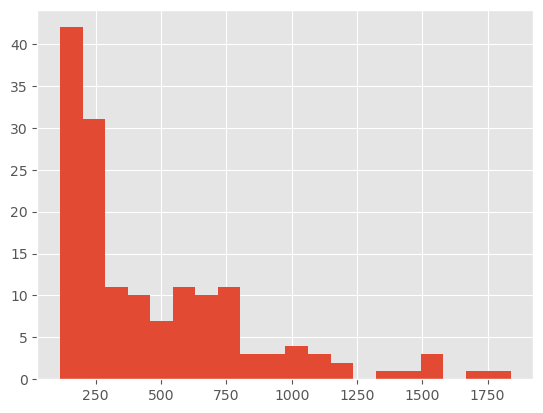

In [5]:
%matplotlib inline
import matplotlib as plt
meuse.zinc.hist(bins = 20)

<Axes: >

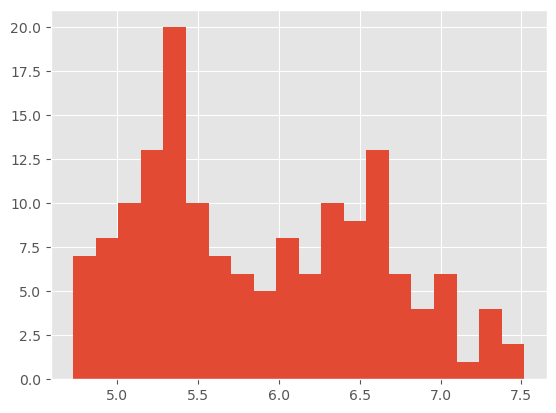

In [6]:
meuse['lzinc'] = np.log(meuse['zinc'])
meuse.lzinc.hist(bins = 20)

And make a quick map of the log-transformed values. As the river shapefile is over a much bigger area, we first create a bounding box from the point data

In [7]:
minx, miny, maxx, maxy = meuse.total_bounds
minx = minx - 100
maxx = maxx + 100
miny = miny - 100
maxy = maxy + 100

(329614.0, 333711.0)

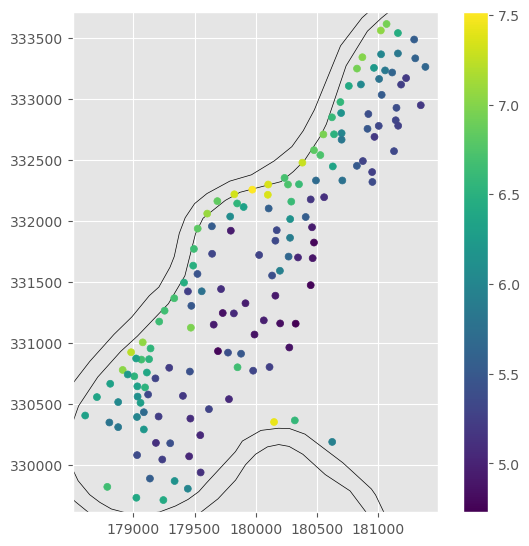

In [8]:
base = meuse_riv.plot(figsize = (6.5, 6.5), edgecolor="black", facecolor="None")
meuse.plot(ax = base, column = 'lzinc', markersize = 25, legend = True)
base.set_xlim(minx, maxx)
base.set_ylim(miny, maxy)

We'll be using the following features to model this: soil type (`soil`), distance to river (`dist`) and flood frequency (`ffreq`). Try making maps of each of these.

## Spatial dependency

One of the key characteristics of spatial data is that they are *structured*: locations that are close together tend to have values that are more similar than locations that are far apart. There are several ways to test autocorrelation is present in your data. Here's we'll use a variogram to show this (we'll also use this in a later part of the lab). 

A variogram plot shows the average difference in values of a variable across a set of spatial *lags*. Put simply, the method finds all the pairs of observations that are separated by a certain distance (e.g. 0-100m, 100-200m, etc) and calculates the difference in the value of some variable for each pair. This is then visualized as the mean of those differences (y-axis) against the lag distance (x-axis). 

We'll use the **scikit-gstat** library in Python to make and plot this for the log-zinc values. First use the `variogram` function to calculate the values. This needs an array or DataFrame with the coordinates of the points, and the variable (`lzinc`) that we want to make the variogram for.

In [9]:
coords = pd.DataFrame({'x': meuse.geometry.x,
                       'y': meuse.geometry.y})

In [10]:
V = skg.Variogram(coords, meuse.lzinc)

/Users/u0784726/miniforge3/envs/geog5160/lib/python3.10/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


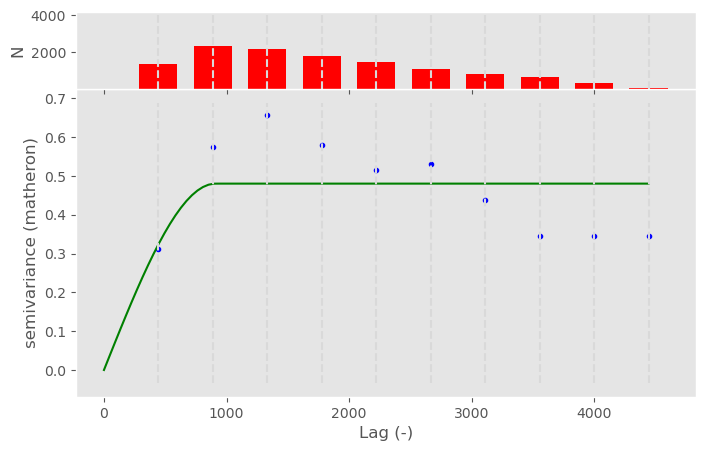

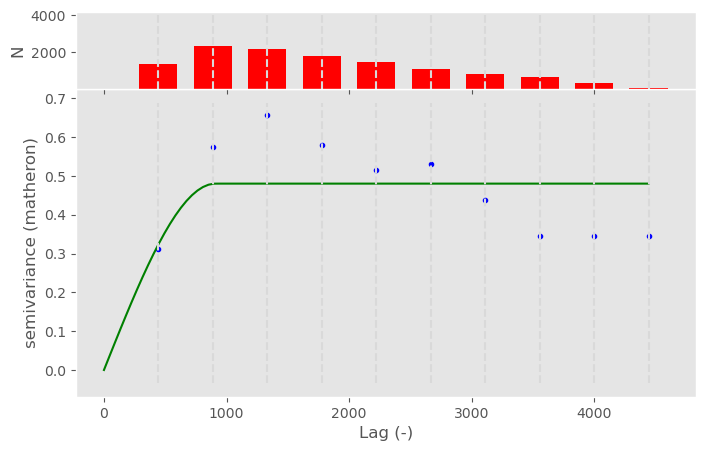

In [11]:
V.plot()

The blue points represent the variogram (the semivariance) as calculated from the data. The green line is a *variogram model* which has been roughly fit to the data - we can ignore this for now. 

Autocorrelation is indicated by lower values of semivariance (y-axis) at shorter separation distances (in the blue points), as clearly shown here. This just means that locations that are separated by less than, say, 100m, tend to have more similar values of zinc than locations that are separated by 500 or 1000m. Note that the points reach a plateau at around 1000m; this is called the **range** and indicates the limit of autocorrelation. We can also set the `maxlag` argument to focus more on the part of the figure showing the decline in semivariance (this limits the x-axis):

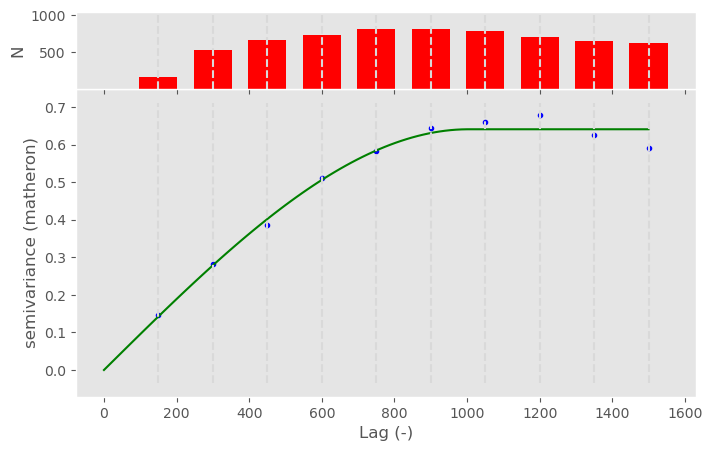

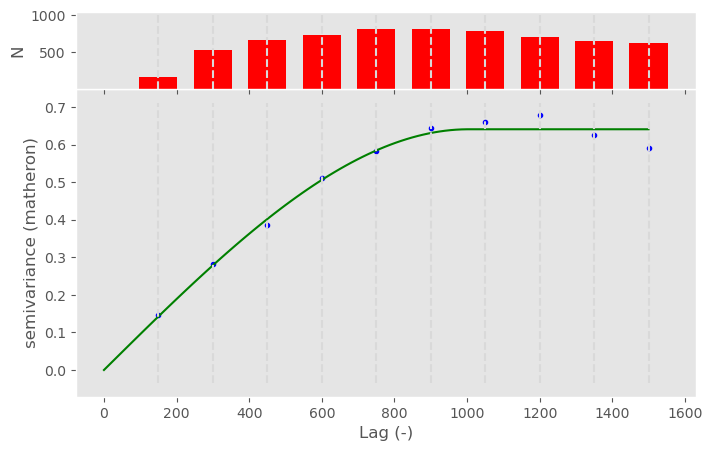

In [12]:
V = skg.Variogram(coords, meuse.lzinc, maxlag = 1500)
V.plot()

We'll return to this figure a little later on in the lab.

## Spatial cross-validation

This spatial autocorrelation indicates that the observations are not independent. When evaluating your models, standard resampling methods that are based on random sampling (e.g., holdout or $k$-fold cross-validation) cannot account for this. Ignoring this can result in over-optimistic estimates of model performance.

Recent work by Hengl and others have shown that stratified or spatial block sampling may be a better approach. Python does have an existing library (spacv) which will do thism, however, there are some current issues with the version of geopandas that it uses. We'll just tackle this by hand to better illustrate what is going on. Before starting though, we'll create a dataset of features (`X`) and the target (`y`):

In [13]:
X = meuse[['soil', 'ffreq', 'dist']]
y = meuse['lzinc']

### Non-spatial cross-validation

As a reference, we'll start with a standard 5-fold cross-validation. We'll use a 5-fold cross-validation, using the `KFold` function

In [14]:
from sklearn.model_selection import KFold

nfold = 5
kf = KFold(n_splits = nfold, shuffle = True)

Normally, we'd simply run this with `cross_val_score` to obtain our scores. But here, we'll save the indexes create by this method so a) we can visualize the results and b) we have a comparative method for the spatial cross validation later. To do this, we create a blank column in `meuse` to store the fold IDs, then loop over and store the label

In [15]:
meuse['nonspatial_fold'] = int(-1)

foldID = int(0)
for train_index, test_index in kf.split(meuse):
    meuse.loc[test_index, 'nonspatial_fold'] = foldID
    foldID += 1
meuse['nonspatial_fold'] = meuse['nonspatial_fold'].astype(str)

Here's a quick map to show the distribution of the 5 folds (as you'll see, these are not spatially stratified in any way):

(329614.0, 333711.0)

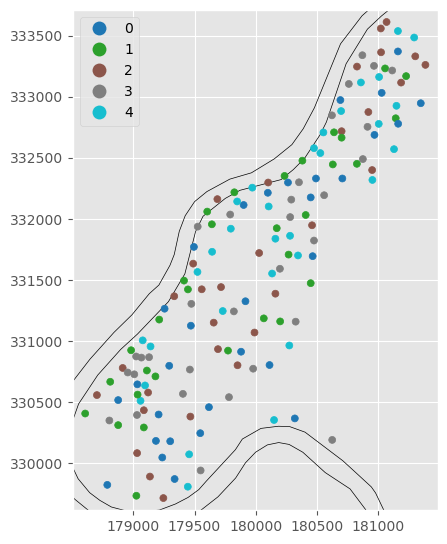

In [16]:
base = meuse_riv.plot(figsize = (6.5, 6.5), edgecolor="black", facecolor="None")
meuse.plot(ax = base, column = 'nonspatial_fold', markersize = 25, legend = True)
base.set_xlim(minx, maxx)
base.set_ylim(miny, maxy)

We can now use these in evaluating our model using `PredefinedSplit`. This takes a vector of indicies to define which observation is in the training and testing sets. Here we use the vector we created in the last step:

In [17]:
from sklearn.model_selection import PredefinedSplit
nonspatial_ps = PredefinedSplit(meuse['nonspatial_fold'])
nonspatial_ps.get_n_splits()

5

To test this, we'll just a basic random forest regressor. We'll set the number of trees to 500, and leave eveything else at default settings

In [18]:
from sklearn import ensemble
rf = ensemble.RandomForestRegressor(n_estimators = 500)

Now we can run the cross validation, using the predefined split strategy created earlier:

In [19]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, y, cv = nonspatial_ps, scoring = 'neg_root_mean_squared_error')

In [20]:
print("%.3f" % np.mean(-scores))

0.426


### Spatial cross-validation

Next, we'll repeat this using a spatially stratified cross-validation strategy. We'll use a simple approach that clusters the locations into folds by estimating $k$-means clusters on the coordinates. First import the relevant function

In [21]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = nfold, random_state=0, n_init="auto")

Then fit using the array of coordinates we extracted earlier:

In [22]:
kmeans.fit(coords)

KMeans(n_clusters=5, n_init='auto', random_state=0)

The cluster numbers are held in `labels_`, so let's extract these and merge them back to the meuse DataFrame (and plot)

In [23]:
kmeans.labels_
meuse['spatial_fold'] = kmeans.labels_.astype(str)

(329614.0, 333711.0)

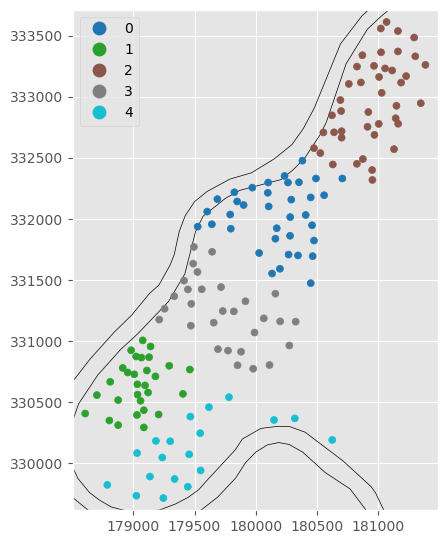

In [24]:
base = meuse_riv.plot(figsize = (6.5, 6.5), edgecolor="black", facecolor="None")
meuse.plot(ax = base, column = 'spatial_fold', markersize = 25, legend = True)
base.set_xlim(minx, maxx)
base.set_ylim(miny, maxy)

Now redefine the splits using these folds:

In [25]:
spatial_ps = PredefinedSplit(meuse['spatial_fold'])
spatial_ps.get_n_splits()

5

And re-run the corss validation to get a more robust estimate of the error

In [26]:
scores = cross_val_score(rf, X, y, cv = spatial_ps, scoring = 'neg_root_mean_squared_error')
print("%.3f" % np.mean(-scores))

0.485


## Incorporating spatial information in machine learning models

When spatial dependency exists in a variable, this can be incorporated in machine learning models to try and improve their predictive skill. Here, we'll look at a simple approach that includes the coordinates as covariates, as well as a more complex method that uses a post-hoc adjustment of the model predictions.

### Including coordinates

This simple approach assumes that dependency can be captured as a function of the coordinates. This amounts to including a latent (i.e. unknown) variable in the model. In practice, this just requires including the `x` and `y` coordinates as additional features. We'll do that now by appending the `coords` DataFrame to the set of selected features `X`:

In [27]:
X.shape

(155, 3)

In [28]:
coords.shape

(155, 2)

In [29]:
X = pd.concat([X, coords], axis = 1)

We can re-use the two different (nonspatial and spatial) cross-validation to evaluate this new model, which shows a fairly large reduction in the error:

In [30]:
## Nono-Spatial CV
scores = cross_val_score(rf, X, y, cv = nonspatial_ps, scoring = 'neg_root_mean_squared_error')
print("%.3f" % np.mean(-scores))

0.357


In [31]:
## Spatial CV
scores = cross_val_score(rf, X, y, cv = spatial_ps, scoring = 'neg_root_mean_squared_error')
print("%.3f" % np.mean(-scores))

0.409


This results in a substantial decrease in the RMSE (although this is based on the non-spatial resampling). It is possible with this approach to visualize the latent spatial field as a partial dependency plot. To do this, we'll train the full model, then use Scikit-Learn's PartialDependenceDisplay to make this plot (as well as the dependency on distance to river:

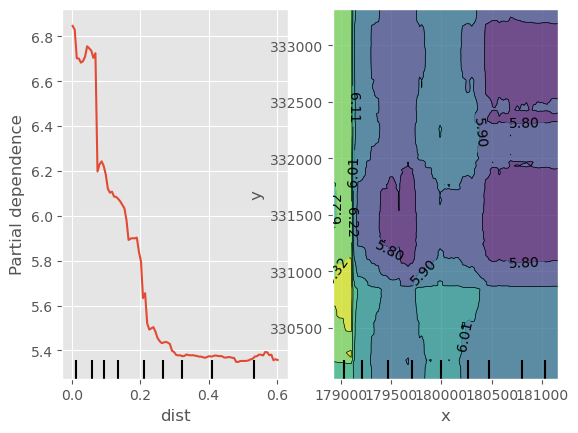

In [32]:
from sklearn.inspection import PartialDependenceDisplay

features = [2, (3, 4)]
rf.fit(X, y)
PartialDependenceDisplay.from_estimator(rf, X, features)

In [33]:
rf

RandomForestRegressor(n_estimators=500)

### Random forest kriging

Finally, we'll try a more complex approach that combines a machine learning model with a spatial interpolation method (kriging). The basis of this approach is that the value of zinc at each location ($s$) can be broken down into three elements:

- A modeled value as a function of the features ($F(x(s))$)
- A spatial error ($u_s$)
- A random error ($v_s$)

In this approach, we 

- Fit a random forest to capture the first of these
- Use the model to predict on a regular grid
- Extract the errors from this at the observations
- Interpolate the errors to the prediction grid
- Add the gridded errors to the model prediction to obtain a final adjusted prediction

As this method currently does not exist in Scikit-Learn (or any other meta package), we'll code this by hand. In the interest of time, we won't cross-validate this, but it is relatively straightforward to do so by looping over either spatial on non-spatial folds we made earlier.

#### Fit the random forest

First we need to remake our set of features (dropping the coordinates), then we'll fit a random forest to the full dataset

In [34]:
features = ['soil', 'ffreq', 'dist']
X = meuse[features]
y = meuse['lzinc']
rf.fit(X, y)

RandomForestRegressor(n_estimators=500)

#### Predict on grid

We previously loaded a prediction grid for the Meuse floodplain (`meuse_grid`). As this has a value of the three features at each grid point, we can use this to make predictions. Note that we have to select the same set of features from the gridded data and in the same order used in training the model. We store the predictions back in the `geopandas` object for visualization


In [35]:
meuse_grid

part_a  part_b      dist soil ffreq                       geometry
0        1.0     0.0  0.000000    1     1  POINT (181180.000 333740.000)
1        1.0     0.0  0.000000    1     1  POINT (181140.000 333700.000)
2        1.0     0.0  0.012224    1     1  POINT (181180.000 333700.000)
3        1.0     0.0  0.043468    1     1  POINT (181220.000 333700.000)
4        1.0     0.0  0.000000    1     1  POINT (181100.000 333660.000)
...      ...     ...       ...  ...   ...                            ...
3098     0.0     1.0  0.005432    1     1  POINT (179060.000 329620.000)
3099     0.0     1.0  0.000000    1     1  POINT (179100.000 329620.000)
3100     0.0     1.0  0.000000    1     2  POINT (179140.000 329620.000)
3101     0.0     1.0  0.000000    1     2  POINT (179180.000 329620.000)
3102     0.0     1.0  0.000000    1     2  POINT (179220.000 329620.000)

[3103 rows x 6 columns]

In [36]:
meuse_grid_df = meuse_grid[features]

In [37]:
meuse_grid['yhat'] = rf.predict(meuse_grid_df)

(329614.0, 333711.0)

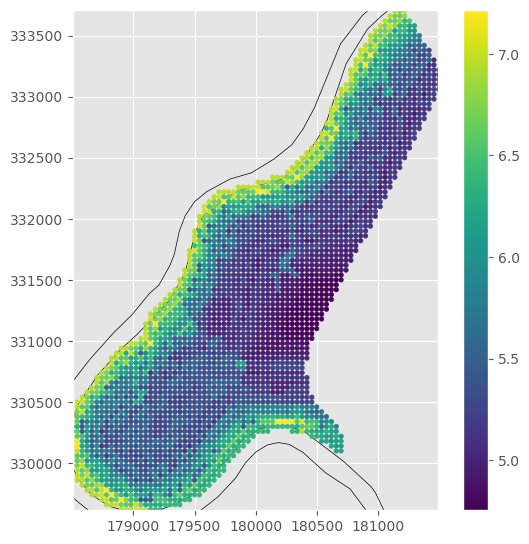

In [38]:
base = meuse_riv.plot(figsize = (6.5, 6.5), edgecolor="black", facecolor="None")
meuse_grid.plot(ax = base, column = 'yhat', markersize = 10, legend = True)
base.set_xlim(minx, maxx)
base.set_ylim(miny, maxy)

#### Get the model errors

To get the model errors at the original locations, we need to first predict values at each site, then calculate the difference between observed and predicted


In [39]:
meuse['yhat'] = rf.predict(X)

meuse['error'] = meuse['lzinc'] - meuse['yhat']

(329614.0, 333711.0)

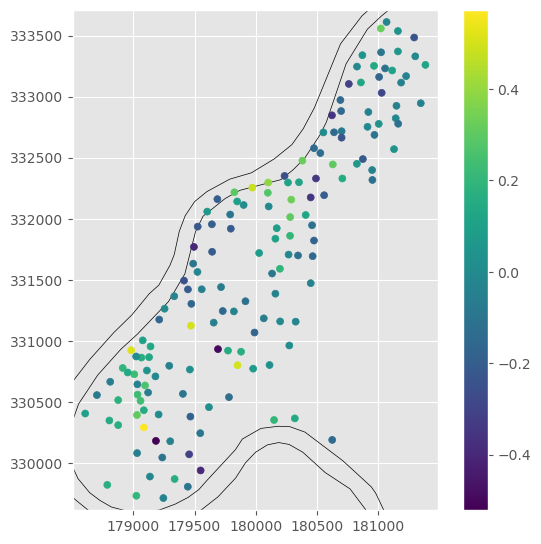

In [40]:
base = meuse_riv.plot(figsize = (6.5, 6.5), edgecolor="black", facecolor="None")
meuse.plot(ax = base, column = 'error', markersize = 25, legend = True)
base.set_xlim(minx, maxx)
base.set_ylim(miny, maxy)

#### Interpolate the model errors

We now need to interpolate these errors to each location on the prediction grid. To do this, we'll update the variogram we made earlier using the model errors

/Users/u0784726/miniforge3/envs/geog5160/lib/python3.10/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


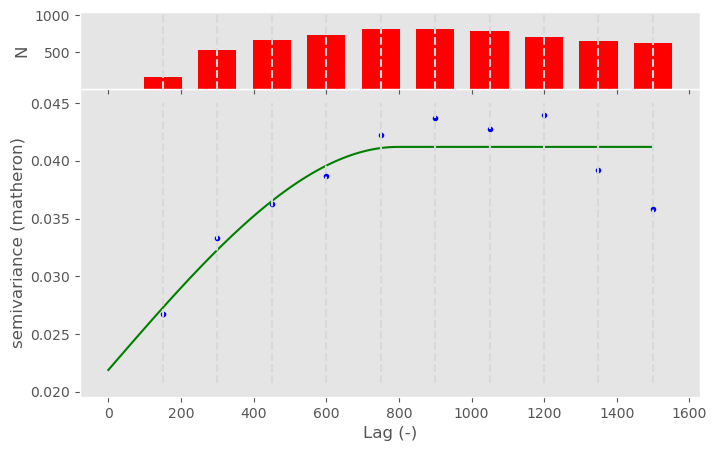

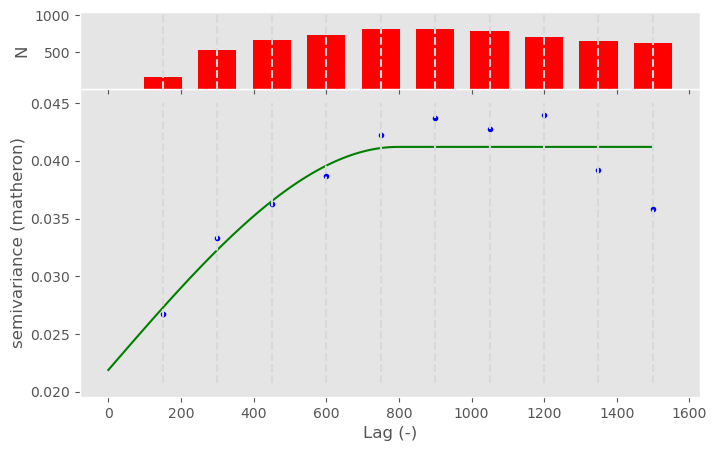

In [41]:
V = skg.Variogram(coords, meuse.error, n_lags = 10, maxlag = 1500, use_nugget = True)
V.plot()

In order to interpolate the errors, we need a continuous variogram model. The `Variogram` function automatically fits one, and in this case has found a good fit to the points. A variogram model is generally defined by three parameters:

1. The *range*: the point on the x-axis where the points reach a plateau (roughly 700m)
2. The *partial sill*: the vertical height above the nugget where the points reach a plateau (roughly 0.02)
3. The *nugget*: the point at which a line through the points would intercept the y-axis (roughly 0.02)

You can see the values for the fitted model with:

In [42]:
print("range: %.2f   sill: %.3f   nugget: %.3f" % (V.parameters[0], V.parameters[1], V.parameters[2]))

range: 796.99   sill: 0.019   nugget: 0.022


Note that if you want to adjust any of these, you can set the values by hand using a `manual` fit method. 

`skg.Variogram(..., fit_method = 'manual', fit_range = 1000, fit_nugget = 0.2, fit_sill = 0.4)`

Now we can interpolate to the grid using this model (`V`) and the `OrdinaryKriging` function. First, we'll get the coordinates of the grid we used previously with the random forest model

In [43]:
grid_coords = pd.DataFrame({'x': meuse_grid.geometry.x,
                            'y': meuse_grid.geometry.y})

Next, set up the kriging function. We need to pass the variogram model to this as well as any limits on the number of points to be used to estimate the value at a new location

In [47]:
from skgstat import OrdinaryKriging
ok = skg.OrdinaryKriging(V, min_points=5, max_points=15, mode='exact')

Finally, the `transform` method runs the interpolation over the grid points

In [48]:
meuse_grid['u'] = ok.transform(grid_coords.x, grid_coords.y)

(329614.0, 333711.0)

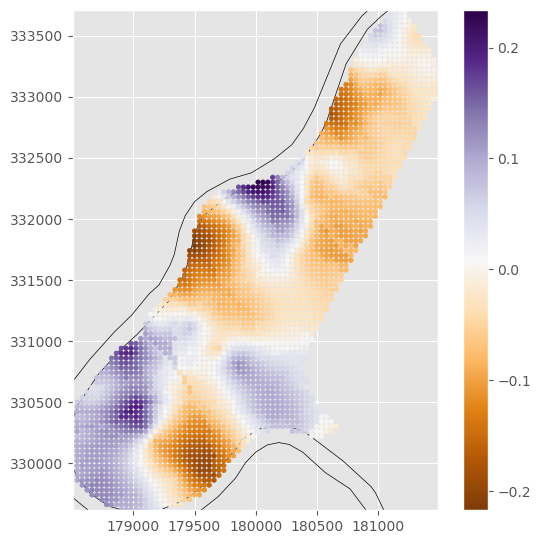

In [49]:
base = meuse_riv.plot(figsize = (6.5, 6.5), edgecolor="black", facecolor="None")
meuse_grid.plot(ax = base, column = 'u', markersize = 10, legend = True, cmap = 'PuOr')
base.set_xlim(minx, maxx)
base.set_ylim(miny, maxy)

Note that the errors tend to be positive along the river edge (where the model underpredicts) and negative on the floodplain

#### Make the final predictions

Our final predictions are now made by adding these errors to the original predictions and plot:

In [51]:
meuse_grid['yhat_adj'] = meuse_grid['yhat'] + meuse_grid['u']

(329614.0, 333711.0)

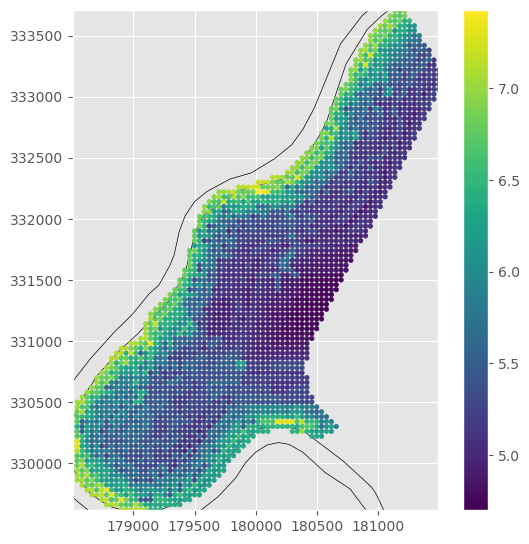

In [53]:
base = meuse_riv.plot(figsize = (6.5, 6.5), edgecolor="black", facecolor="None")
meuse_grid.plot(ax = base, column = 'yhat_adj', markersize = 10, legend = True)
base.set_xlim(minx, maxx)
base.set_ylim(miny, maxy)